# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-22 00:21:08.743181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

2023-10-22 00:21:15.709570: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.normal([in_features, out_features]),
                             name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Первый слой, состоящий из 128 нейронов
        # Место для вашего кода
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

        # Второй слой, состоящий из 256 нейронов
        # Место для вашего кода
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

        # Выходной слой
        # Место для вашего кода
        self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        # Место для вашего кода
        x1 = self.layer_1(x, activation=0)
        x2 = self.layer_2(x1, activation=0)
        x3 = self.layer_3(x2, activation=1)

        # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
        # Делаем мы это для того, чтобы
        # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
        # принадлежности входного объекта к одному из 10 классов

        # x = # Место для вашего кода
        return x3

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    accuracy = tf.metrics.Accuracy()
    accuracy.update_state(y_true, tf.argmax(y_pred, axis=1))
    return accuracy.result()

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    # Место для вашего кода
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
# for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Место для вашего кода
        loss_right_now = cross_entropy(pred, batch_y)
        loss_history.append(loss_right_now)

        accuracy_right_now = accuracy(pred, batch_y)
        accuracy_history.append(accuracy_right_now)
        print(f"{'{:4d}'.format(step)}) \t  Loss={loss_right_now}    \t Accuracy={accuracy_right_now}")

2023-10-22 00:21:48.495895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,784]
	 [[{{node Placeholder/_0}}]]
2023-10-22 00:21:48.498112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]


   0) 	  Loss=3856.850341796875    	 Accuracy=0.1484375
 100) 	  Loss=755.5529174804688    	 Accuracy=0.6875
 200) 	  Loss=316.47698974609375    	 Accuracy=0.7109375
 300) 	  Loss=188.7941131591797    	 Accuracy=0.8125
 400) 	  Loss=134.10787963867188    	 Accuracy=0.81640625
 500) 	  Loss=180.00531005859375    	 Accuracy=0.796875
 600) 	  Loss=161.64500427246094    	 Accuracy=0.81640625
 700) 	  Loss=100.6385498046875    	 Accuracy=0.89453125
 800) 	  Loss=76.25656127929688    	 Accuracy=0.8984375
 900) 	  Loss=124.70631408691406    	 Accuracy=0.87109375
1000) 	  Loss=123.85843658447266    	 Accuracy=0.859375
1100) 	  Loss=123.15861511230469    	 Accuracy=0.87890625
1200) 	  Loss=114.92924499511719    	 Accuracy=0.87890625
1300) 	  Loss=59.01234817504883    	 Accuracy=0.921875
1400) 	  Loss=79.16639709472656    	 Accuracy=0.8984375
1500) 	  Loss=94.18424224853516    	 Accuracy=0.90234375
1600) 	  Loss=114.3295669555664    	 Accuracy=0.875
1700) 	  Loss=78.90201568603516    	 Accuracy=

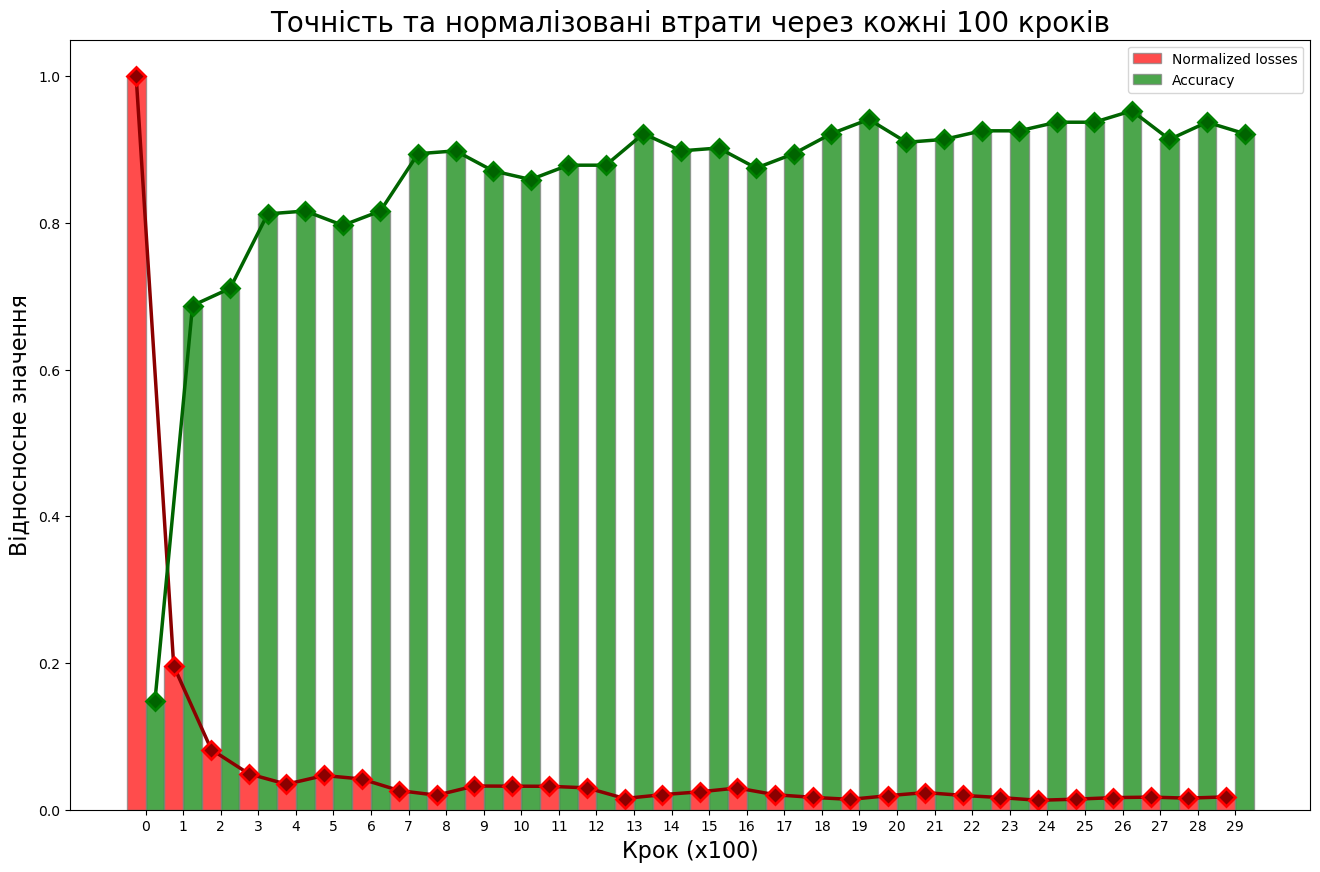

In [8]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода

# Normalizing loss_history
loss_histnorm = loss_history / max(loss_history)

BARWIDTH = 0.5 # set width of bar
plt.subplots(figsize=(16, 10))

# Set position of bar on X axis 
br1 = np.arange(len(loss_histnorm))
br2 = [v + BARWIDTH for v in br1]

plt.bar(br1, loss_histnorm, color='r', alpha=0.7, width=BARWIDTH, 
        edgecolor='grey', label='Normalized losses') 
plt.bar(br2, accuracy_history, color='g', alpha=0.7, width=BARWIDTH, 
        edgecolor='grey', label='Accuracy') 
plt.plot(br1, loss_histnorm, '-', color ='darkred', linewidth=2.5,
        marker="D", markersize=9, markeredgecolor="red", markeredgewidth=2)
plt.plot(br2, accuracy_history, '-', color ='darkgreen', linewidth=2.5,
        marker="D", markersize=9, markeredgecolor="green", markeredgewidth=2)

plt.xlabel(f"Крок (x{display_step})", fontsize=16) 
plt.ylabel('Відносносне значення', fontsize=16) 
plt.xticks([r + BARWIDTH/2 for r in range(len(loss_histnorm))], 
           [r for r in range(len(loss_histnorm))])
 
plt.title(f"Точність та нормалізовані втрати через кожні {display_step} кроків", fontsize=20)
plt.legend()
plt.show()

In [9]:
# Вычислите точность обученной нейросети

# Место для вашего кода
learned_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Learned Neural Net Accuracy is {learned_net_accuracy}")

Learned Neural Net Accuracy is 0.9225999712944031


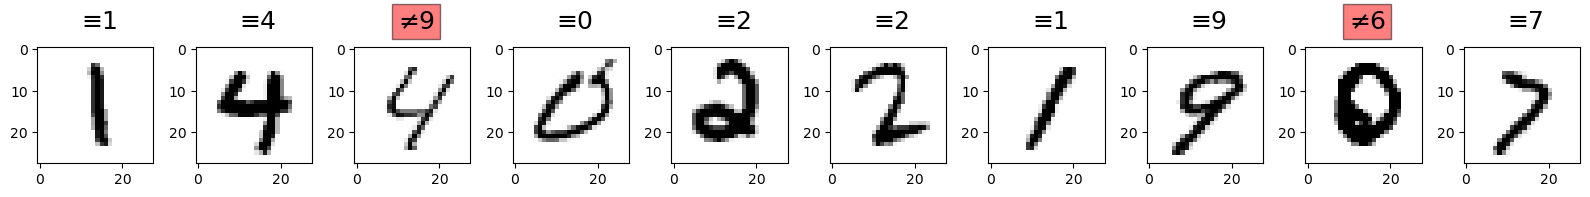

In [10]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода

plt.figure(figsize=(16, 6))
for i in range(1,11):
    rind = np.random.randint(x_test.shape[0])
    test_digit = y_test[rind]
    predicted_digit = np.argmax(neural_net([x_test[rind]]))
    compare = "≡"
    bbox = None
    if test_digit != predicted_digit:
        compare = "≠"
        bbox = dict(facecolor='red', alpha=0.5)
    plt.subplot(1, 10, i)
    plt.imshow(x_test[rind].reshape(28, 28), cmap='binary') 
    plt.text(x=10, y=-5, s=f"{compare}{predicted_digit}", fontsize=18, bbox=bbox)
    
plt.tight_layout()
plt.show()